In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/benign_malignant_network_build'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Configure memory growth for GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Memory growth setting failed:", e)

GPU Available:  []
TensorFlow version: 2.17.0


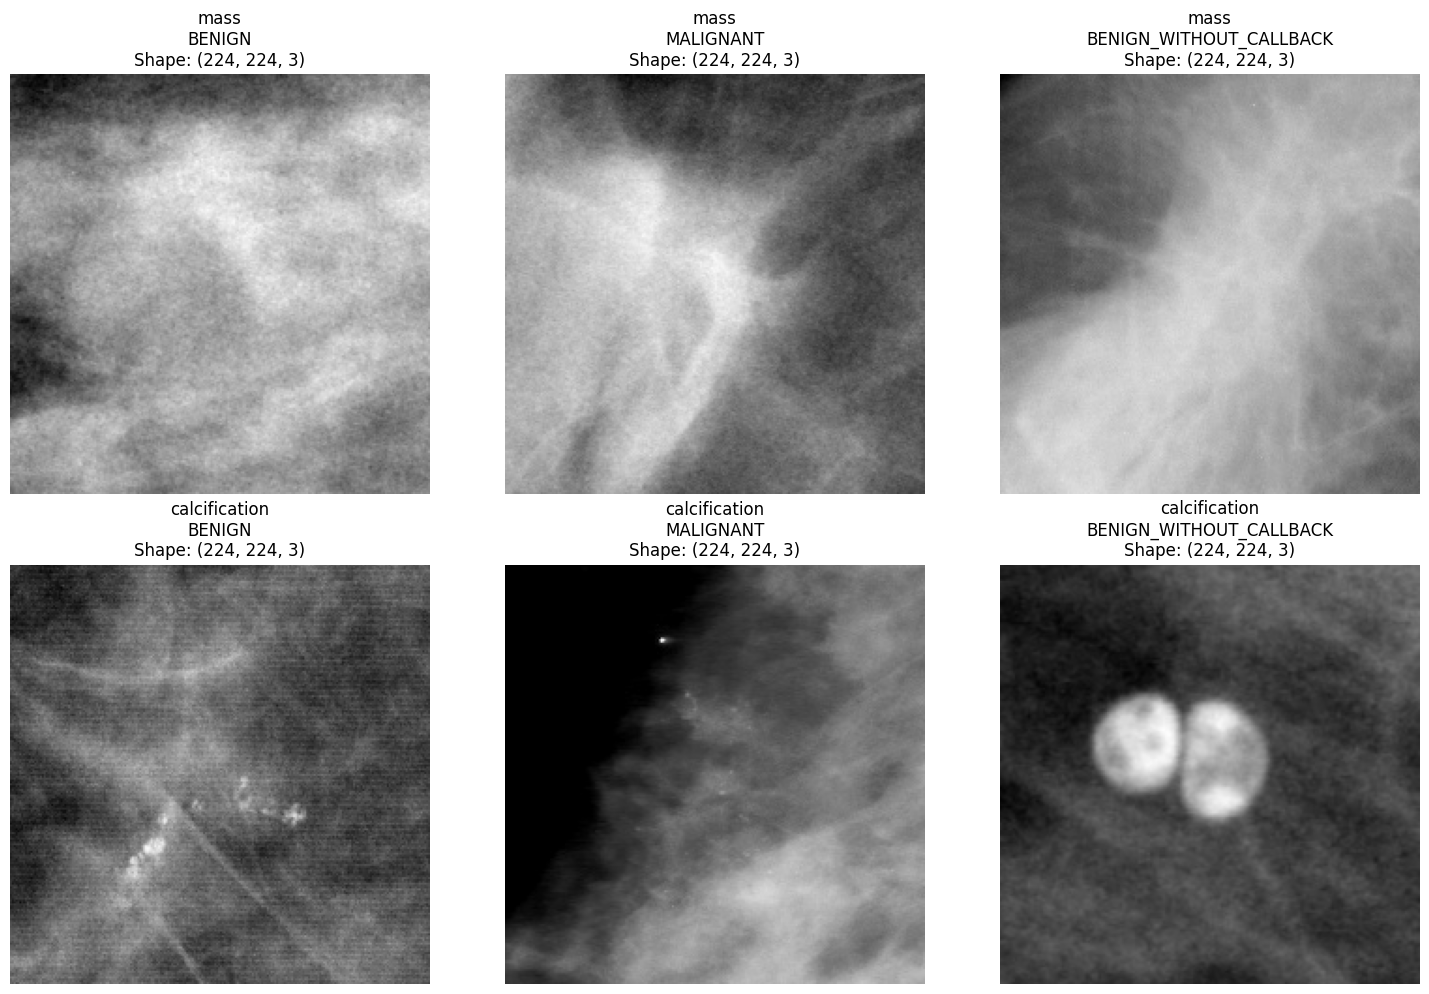

In [5]:
def display_sample_images(base_path, num_samples=3):
    categories = ['BENIGN', 'MALIGNANT', 'BENIGN_WITHOUT_CALLBACK']
    types = ['mass', 'calcification']

    fig = plt.figure(figsize=(15, 10))

    for type_idx, type_name in enumerate(types):
        for cat_idx, category in enumerate(categories):
            plot_idx = type_idx * len(categories) + cat_idx + 1

            path = os.path.join(base_path, type_name, 'train', 'cropped_files', category)
            try:
                image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                if image_files:
                    img_file = np.random.choice(image_files)
                    img_path = os.path.join(path, img_file)

                    img = tf.keras.preprocessing.image.load_img(img_path)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)

                    plt.subplot(2, 3, plot_idx)
                    plt.imshow(img_array.astype(np.uint8))
                    plt.title(f'{type_name}\n{category}\nShape: {img_array.shape}')
                    plt.axis('off')
            except Exception as e:
                print(f"Error processing {path}: {str(e)}")

    plt.tight_layout()
    plt.show()

display_sample_images(data_dir)

In [6]:
train_gen = image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

test_gen = image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

In [7]:
mass_train_generator = train_gen.flow_from_directory(
    os.path.join(data_dir, 'mass/train/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

mass_val_generator = test_gen.flow_from_directory(
    os.path.join(data_dir, 'mass/test/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

calc_train_generator = train_gen.flow_from_directory(
    os.path.join(data_dir, 'calcification/train/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

calc_val_generator = test_gen.flow_from_directory(
    os.path.join(data_dir, 'calcification/test/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 626 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Found 749 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [8]:
def create_model(input_shape=(224, 224, 3), num_classes=3, model_type="mass"):
    base_model = ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.ReLU):
            layer_config = layer.get_config()
            new_layer = tf.keras.layers.LeakyReLU(alpha=0.01)
            new_layer.name = layer.name
            layer_config['name'] = layer.name
            new_layer.from_config(layer_config)
            idx = base_model.layers.index(layer)
            base_model.layers[idx] = new_layer

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(180)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f'resnet101_{model_type}')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

In [10]:
print("Training Mass Model...")
mass_model = create_model(model_type="mass")
mass_history = mass_model.fit(
    mass_train_generator,
    validation_data=mass_val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Training Mass Model...
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 376s 9s/step - accuracy: 0.4574 - loss: 1.3148 - val_accuracy: 0.6136 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 373s 9s/step - accuracy: 0.6147 - loss: 0.8654 - val_accuracy: 0.5693 - val_loss: 1.0107 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.6735 - loss: 0.7540 - val_accuracy: 0.6106 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - accuracy: 0.6558 - loss: 0.7469 - val_accuracy: 0.4720 - val_loss: 1.2621 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - accuracy: 0.6916 - loss: 0.7099 - val_accuracy: 0.6313 - val_loss: 0.9739 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - accuracy: 0.7829 - loss: 0.5716 - val_accuracy: 0.5752 - val_loss: 1.0241 - learning_rate: 0.0010
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.7673 - loss: 0.5384 - val_accuracy: 0.59

In [11]:
mass_model.summary()

Model: "resnet101_mass"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 180)                 │         368,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 180)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,766,267 (166.96 MB)

 Trainable params: 369,363 (1.41 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 738,728 (2.82 MB)

In [12]:
print("\nTraining Calcification Model...")
calc_model = create_model(model_type="calcification")
calc_history = calc_model.fit(
    calc_train_generator,
    validation_data=calc_val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Training Calcification Model...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 409s 8s/step - accuracy: 0.5279 - loss: 1.2259 - val_accuracy: 0.5748 - val_loss: 0.8449 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 410s 8s/step - accuracy: 0.6469 - loss: 0.7323 - val_accuracy: 0.6013 - val_loss: 0.8059 - learning_rate: 0.0010
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.7483 - loss: 0.5609 - val_accuracy: 0.5847 - val_loss: 0.8366 - learning_rate: 0.0010
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.6962 - loss: 0.5832 - val_accuracy: 0.5581 - val_loss: 0.8620 - learning_rate: 0.0010
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 399s 9s/step - accuracy: 0.7477 - loss: 0.5288 - val_accuracy: 0.5847 - val_loss: 0.8403 - learning_rate: 0.0010
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 402s 8s/step - accuracy: 0.8072 - loss: 0.4516 - val_accuracy: 0.5648 - val_loss: 0.9034 - learning_rate: 0.0010
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 362s 8s/step - accuracy

In [13]:
calc_model.summary()

Model: "resnet101_calcification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 180)                 │         368,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 180)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,766,267 (166.96 MB)

 Trainable params: 369,363 (1.41 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 738,728 (2.82 MB)

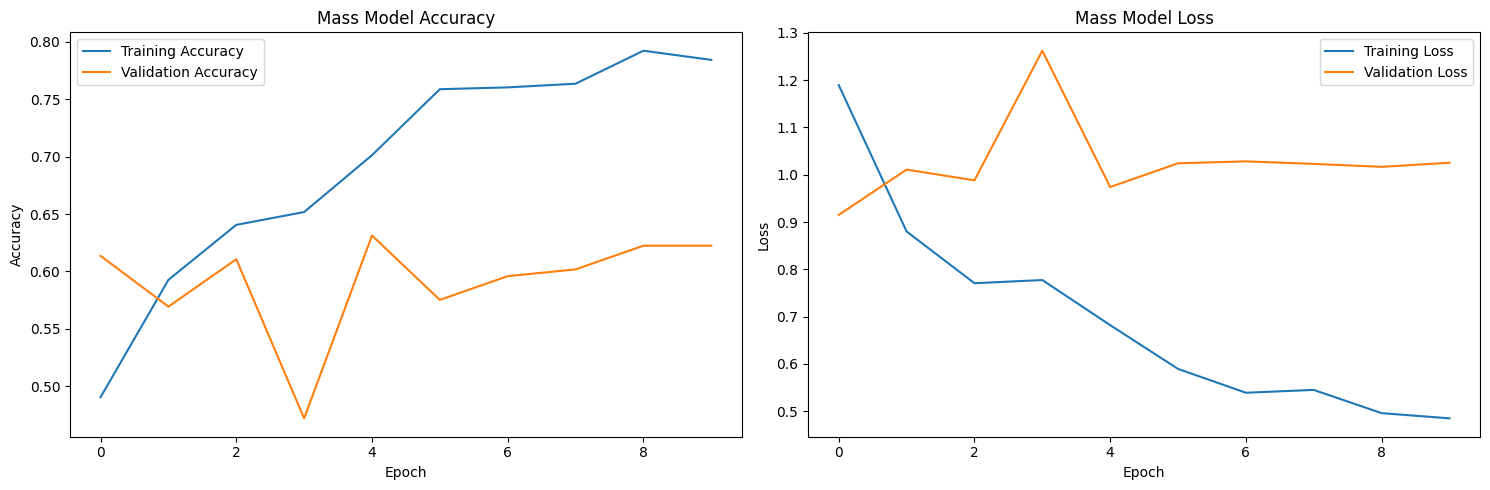

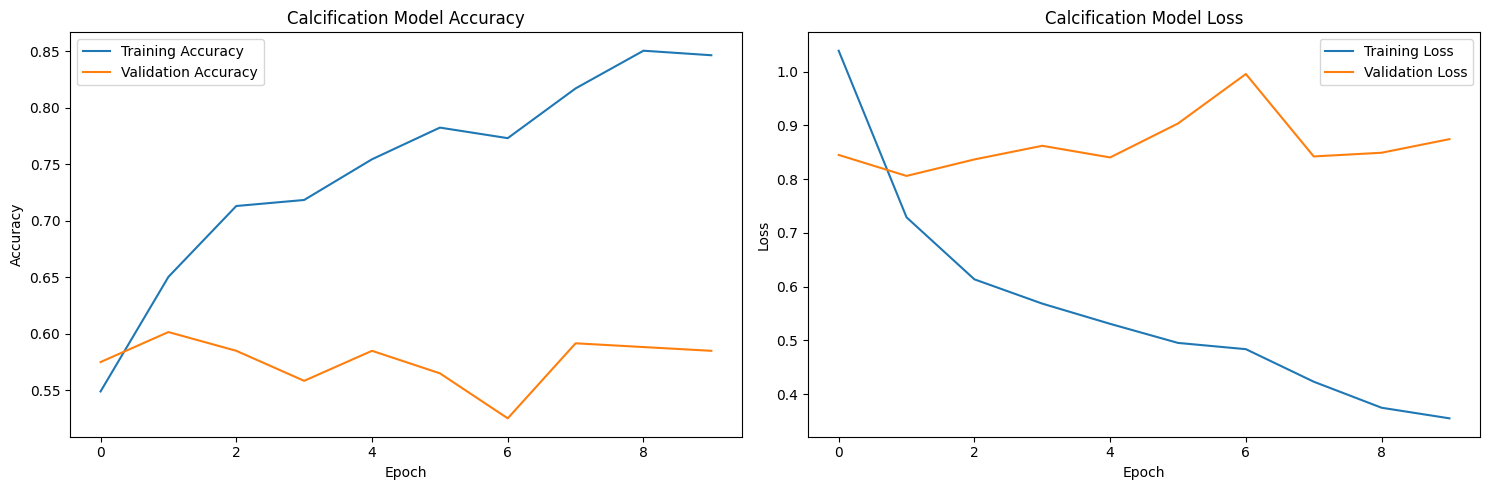

In [14]:
def plot_history(history, model_type):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_type} Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_type} Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_history(mass_history, 'Mass')
plot_history(calc_history, 'Calcification')



Making predictions on test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


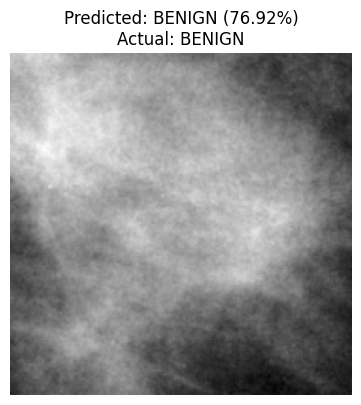

Test 1    Predicted: BENIGN (76.92%)    Actual: BENIGN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


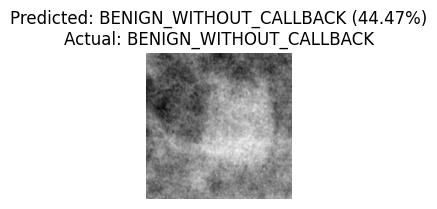

Test 2    Predicted: BENIGN_WITHOUT_CALLBACK (44.47%)    Actual: BENIGN_WITHOUT_CALLBACK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


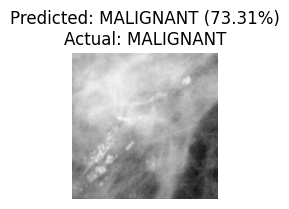

Test 3    Predicted: MALIGNANT (73.31%)    Actual: MALIGNANT


<Figure size 640x480 with 0 Axes>

In [15]:
prediction_labels = list(mass_val_generator.class_indices.keys())

benign_path = os.path.join(data_dir, 'mass/test/cropped_files/BENIGN/1-010.jpg')
bwc_path = os.path.join(data_dir, 'mass/test/cropped_files/BENIGN_WITHOUT_CALLBACK/1-050.jpg')
malignant_path = os.path.join(data_dir, 'mass/test/cropped_files/MALIGNANT/1-027.jpg')

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_batch.copy())

def predict_and_display(model, image_path, actual_class):
    processed_img = load_and_preprocess_image(image_path)

    prediction = model.predict(processed_img)
    predicted_class = prediction_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} ({confidence:.2f}%)\nActual: {actual_class}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

print("\nMaking predictions on test images...")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
predicted_class, confidence = predict_and_display(mass_model, benign_path, "BENIGN")
print(f"Test 1    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN")

plt.subplot(1, 3, 2)
predicted_class, confidence = predict_and_display(mass_model, bwc_path, "BENIGN_WITHOUT_CALLBACK")
print(f"Test 2    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN_WITHOUT_CALLBACK")

plt.subplot(1, 3, 3)
predicted_class, confidence = predict_and_display(mass_model, malignant_path, "MALIGNANT")
print(f"Test 3    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: MALIGNANT")

plt.tight_layout()
plt.show()


Making predictions on calcification test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


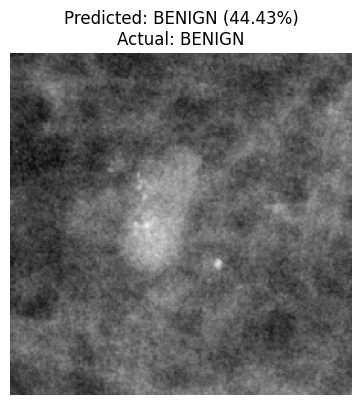

Calc Test 1    Predicted: BENIGN (44.43%)    Actual: BENIGN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


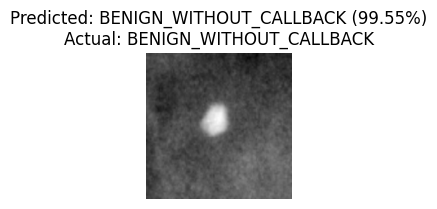

Calc Test 2    Predicted: BENIGN_WITHOUT_CALLBACK (99.55%)    Actual: BENIGN_WITHOUT_CALLBACK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


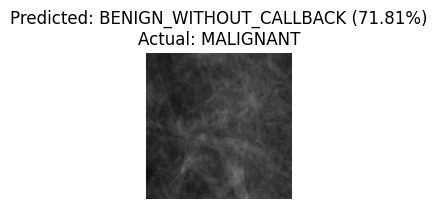

Calc Test 3    Predicted: BENIGN_WITHOUT_CALLBACK (71.81%)    Actual: MALIGNANT


<Figure size 640x480 with 0 Axes>

In [16]:
print("\nMaking predictions on calcification test images...")
calc_benign_path = os.path.join(data_dir, 'calcification/test/cropped_files/BENIGN/1-000.jpg')
calc_bwc_path = os.path.join(data_dir, 'calcification/test/cropped_files/BENIGN_WITHOUT_CALLBACK/1-001.jpg')
calc_malignant_path = os.path.join(data_dir, 'calcification/test/cropped_files/MALIGNANT/1-011.jpg')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
predicted_class, confidence = predict_and_display(calc_model, calc_benign_path, "BENIGN")
print(f"Calc Test 1    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN")

plt.subplot(1, 3, 2)
predicted_class, confidence = predict_and_display(calc_model, calc_bwc_path, "BENIGN_WITHOUT_CALLBACK")
print(f"Calc Test 2    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN_WITHOUT_CALLBACK")

plt.subplot(1, 3, 3)
predicted_class, confidence = predict_and_display(calc_model, calc_malignant_path, "MALIGNANT")
print(f"Calc Test 3    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: MALIGNANT")

plt.tight_layout()
plt.show()